Changelog:
1. This notebook is a copy of Kaggle's V8V8 with a Public LB score of 0.8826
2. This has been enhanced with Cross validation on top

# Settings

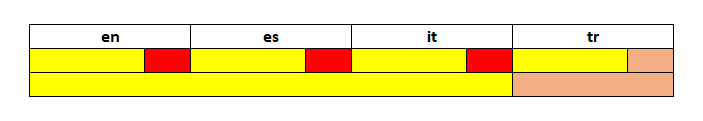

In [1]:
# CONTROLS
MODEL_PREFIX = "V11"
MODEL_NUMBER = MODEL_PREFIX[-2:]
MODEL_NAME = 'distilbert' # options include 'xlm' or 'distilbert'

NUM_EPOCHS = [4, 8, 2]
LR = 5e-4
MAX_SEQ_LEN = 128
SAMPLE_SIZE = 6000
PSUEDO_QUANTILE_THRESH_HIGH = 0.95
PSUEDO_QUANTILE_THRESH_LOW = 0.05

RUN_ON_SAMPLE = 0
if RUN_ON_SAMPLE>0:
    SAMPLE_SIZE = RUN_ON_SAMPLE

ON_KAGGLE = False

if ON_KAGGLE:
    BATCH_SIZE = 32
    PREDICT_BATCH_SIZE = 512
else:
    BATCH_SIZE = 16
    PREDICT_BATCH_SIZE = 256

TRAIN_SPLIT_RATIO = 0.2
DROPOUT = 0.3
LABEL_SMOOTHING_PARAM = 0.1

In [2]:
if ON_KAGGLE:
    RESULTS_DIR = '../working/'
    DATA_DIR = '../input/jigsaw-multilingual-toxic-comment-classification/'
    if MODEL_NAME == 'xlm':
        MODEL_DIR = '../input/tf-xlm-roberta-base/'
    else:
        MODEL_DIR = '../input/tf-distilbert-base-multilingual-cased/'
else:
    PATH = ".."
    RESULTS_DIR = PATH+"/results/"
    DATA_DIR = PATH+"/data/"
    if MODEL_NAME == 'xlm':
        MODEL_DIR = PATH+"/models/tf-xlm-roberta-base/"
    else:
        MODEL_DIR = PATH+"/models/distilbert-base-multilingual-cased/"

# Libraries

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, classification_report, roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold, LeaveOneGroupOut
from sklearn.utils import class_weight

import pickle, os, sys, re, json, gc
from time import time, ctime
from pprint import pprint
from collections import Counter

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv1D, Conv2D, LSTM, Embedding, Dense, concatenate, MaxPooling2D, Softmax, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout, Reshape, Activation, Bidirectional, TimeDistributed
from tensorflow.keras.layers import RepeatVector, Multiply, Layer, LeakyReLU, Subtract
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.callbacks import *
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.utils import to_categorical

import tokenizers, transformers
from transformers import *

import tensorflow_addons as tfa
from tensorflow_addons.optimizers import TriangularCyclicalLearningRate

%matplotlib inline

In [4]:
seeded_value = 987258
pd.set_option('display.max_colwidth', None)
np.random.seed(seeded_value)
tf.random.set_seed(seeded_value)

In [5]:
print(ctime(time()))

Sat Jun 20 23:28:37 2020


In [6]:
print([
    tf.__version__,
    transformers.__version__,
    tokenizers.__version__
])

['2.1.0', '2.8.0', '0.5.2']


<a href="https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth"  target="_blank"><h2 id="limiting_gpu_memory_growth" data-text="Limiting GPU memory growth" tabindex="0">Limiting GPU memory growth</h2></a>
<p>By default, TensorFlow maps nearly all of the GPU memory of all GPUs (subject to
<a href="https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#env-vars"><code translate="no" dir="ltr">CUDA_VISIBLE_DEVICES</code></a>) visible to the process. This is done to more efficiently use the relatively precious GPU memory resources on the devices by reducing memory fragmentation. To limit TensorFlow to a specific set of GPUs we use the <code translate="no" dir="ltr">tf.config.experimental.set_visible_devices</code> method.</p>

In [7]:
print(tf.config.experimental.list_logical_devices('CPU'))
print(tf.config.experimental.list_logical_devices('GPU'))
print(tf.config.experimental.list_physical_devices('CPU'))
print(tf.config.experimental.list_physical_devices('GPU'))

[LogicalDevice(name='/device:CPU:0', device_type='CPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

# Import Data

In [9]:
train = pd.read_csv(DATA_DIR+'jigsaw-toxic-comment-train.csv')
validation = pd.read_csv(DATA_DIR+'validation.csv')
test = pd.read_csv(DATA_DIR+'test.csv')

In [10]:
train['lang'] = 'en'

train['set'] = 'train'
validation['set'] = 'valid'
test['set'] = 'test'

test['toxic'] = 0

In [11]:
print(train.columns)
print(validation.columns)
print(test.columns)

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'lang', 'set'],
      dtype='object')
Index(['id', 'comment_text', 'lang', 'toxic', 'set'], dtype='object')
Index(['id', 'content', 'lang', 'set', 'toxic'], dtype='object')


In [12]:
validation.lang.unique(), test.lang.unique()

(array(['es', 'it', 'tr'], dtype=object),
 array(['tr', 'ru', 'it', 'fr', 'pt', 'es'], dtype=object))

In [13]:
train.columns = ['id', 'text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'lang', 'set']
validation.columns = ['id', 'text', 'lang', 'toxic', 'set']
test.columns = ['id', 'text', 'lang', 'set', 'toxic']

In [14]:
REQ_COLS = ['id', 'set', 'text', 'lang', 'toxic']

In [15]:
train['text'] = train["text"].astype(str)
validation['text'] = validation["text"].astype(str)
test['text'] = test["text"].astype(str)

In [16]:
data = pd.concat([train[REQ_COLS].sample(SAMPLE_SIZE, random_state=seeded_value),
                  validation[REQ_COLS]], axis=0)

In [17]:
data.shape

(14000, 5)

In [18]:
data.sample(2)

,id,set,text,lang,toxic
164112,126f4ebe96739a72,train,""" \n\n *Support I have heard of the region before as Nakhichevan. \n *Support Nakhichevan is the common name of the area in English. """,en,0
4631,4631,valid,"¿Bastardilla?¿Pero no se decía cursiva?.Creo que sería mejor poner cursiva , en vez de bastardilla . Super",es,0


In [19]:
data.groupby(["set", "lang"]).agg({'id':'count', 'toxic':np.mean})

id     toxic
set   lang                
train en    6000  0.092667
valid es    2500  0.168800
      it    2500  0.195200
      tr    3000  0.106667

In [20]:
test.groupby(["set", "lang"]).agg({'id':'count', 'toxic':np.mean})

id  toxic
set  lang              
test es     8438      0
     fr    10920      0
     it     8494      0
     pt    11012      0
     ru    10948      0
     tr    14000      0

In [21]:
if RUN_ON_SAMPLE>0:
    data = data.sample(RUN_ON_SAMPLE).copy().reset_index(drop=True)
    test = test.sample(RUN_ON_SAMPLE).copy().reset_index(drop=True)

# Tokenizer, Config & Model Initialization

1. https://arxiv.org/pdf/1911.02116.pdf
2. https://huggingface.co/transformers/model_doc/xlmroberta.html

In [22]:
if MODEL_NAME == 'xlm':
    xlmr_tok = transformers.XLMRobertaTokenizer.from_pretrained(MODEL_DIR)
else:
    xlmr_tok = transformers.DistilBertTokenizer.from_pretrained(MODEL_DIR)

In [23]:
with open(MODEL_DIR+"special_tokens_map.json") as f:
    special_tokens = json.load(f)
xlmr_tok.add_special_tokens(special_tokens)

0

In [24]:
VOCAB_SIZE = xlmr_tok.vocab_size
print(VOCAB_SIZE)

119547


# Tokenization

In [25]:
X_tokens, X_att = [], []
for t in data.text.tolist():
    encoded_text = xlmr_tok.encode_plus(t, pad_to_max_length=True, max_length=MAX_SEQ_LEN)
    X_tokens.append(encoded_text['input_ids'])
    X_att.append(encoded_text['attention_mask'])

X_tokens, X_att, X_lang, Y_toxic = np.array(X_tokens), np.array(X_att), data['lang'].values, data['toxic'].values

In [26]:
X_tokens_test, X_att_test = [], []
for t in test.text.tolist():
    encoded_text = xlmr_tok.encode_plus(t, pad_to_max_length=True, max_length=MAX_SEQ_LEN)
    X_tokens_test.append(encoded_text['input_ids'])
    X_att_test.append(encoded_text['attention_mask'])

X_tokens_test, X_att_test, X_lang_test = np.array(X_tokens_test), np.array(X_att_test), test['lang'].values

print("\n",
      X_tokens_test.shape, "\t: X_tokens_test ", "\n",
      X_att_test.shape, "\t: X_att_test ", "\n"
)


 (63812, 128) 	: X_tokens_test  
 (63812, 128) 	: X_att_test  



# Model Specifications

In [27]:
def build_model():
    input_sequences = Input((MAX_SEQ_LEN), dtype=tf.int32, name="words")
    input_att_flags = Input((MAX_SEQ_LEN), dtype=tf.int32, name="att_flags")
    
    if MODEL_NAME == 'xlm':
        config = transformers.XLMRobertaConfig.from_pretrained(MODEL_DIR)
        model = transformers.TFXLMRobertaModel.from_pretrained(MODEL_DIR, config=config) # TFXLMRobertaForSequenceClassification
        x = model(inputs=input_sequences, attention_mask=input_att_flags)
    else:
        config = transformers.DistilBertConfig.from_pretrained(MODEL_DIR)
        model = transformers.TFDistilBertModel.from_pretrained(MODEL_DIR) # TFDistilBertForSequenceClassification
        x = model(inputs=input_sequences, attention_mask=input_att_flags)
    
    x1 = tf.keras.layers.Dropout(DROPOUT)(x[0])
    x1 = tf.keras.layers.Conv1D(768, 2, padding='same')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.Dense(1)(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Dense(1)(x1)
    toxic_output = tf.keras.layers.Activation('sigmoid', name="toxic_output")(x1)
    
    model = Model([input_att_flags, input_sequences],
                  [toxic_output])
    
    return model

In [28]:
model = build_model()

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words (InputLayer)              [(None, 128)]        0                                            
__________________________________________________________________________________________________
att_flags (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB ((None, 128, 768),)  134734080   words[0][0]                      
__________________________________________________________________________________________________
dropout_19 (Dropout)            (None, 128, 768)     0           tf_distil_bert_model[0][0]       
______________________________________________________________________________________________

# Cross Validation Strategy

KFold train-validation split

In [30]:
NUM_FOLDS = 5
kf = KFold(NUM_FOLDS, shuffle=True, random_state=seeded_value)

KFold Stratified train-validation split

In [31]:
#NUM_FOLDS = 3
#skf = StratifiedKFold(NUM_FOLDS, shuffle=True, random_state=seeded_value)

Leave one language out split

In [32]:
#logo = LeaveOneGroupOut()
#for t_index, v_index in logo.split(np.arange(X_tokens.shape[0]), np.arange(X_tokens.shape[0]), groups=X_lang):
#    print(X_lang[t_index])
#    #print(np.unique(X_lang[v_index]))

Simple random train-validation split

In [33]:
#t_index, v_index = train_test_split(np.arange(X_tokens.shape[0]), shuffle=True, random_state=seeded_value)

# Model Fit

<a href="https://keras.io/guides/transfer_learning/#finetuning" target="_blank"><h2 id="finetuning">Fine-tuning</h2></a>
<p>Once your model has converged on the new data, you can try to unfreeze all or part of
 the base model and retrain the whole model end-to-end with a very low learning rate.</p>
 <p>This is an optional last step that can potentially give you incremental improvements.
 It could also potentially lead to quick overfitting -- keep that in mind.</p>
 <p>It is critical to only do this step <em>after</em> the model with frozen layers has been
trained to convergence. If you mix randomly-initialized trainable layers with
trainable layers that hold pre-trained features, the randomly-initialized layers will
cause very large gradient updates during training, which will destroy your pre-trained
 features.</p>
 <p>It's also critical to use a very low learning rate at this stage, because
you are training a much larger model than in the first round of training, on a dataset
 that is typically very small.
As a result, you are at risk of overfitting very quickly if you apply large weight
 updates. Here, you only want to readapt the pretrained weights in an incremental way.</p>

<a href="https://keras.io/guides/transfer_learning/#finetuning" target="_blank"><p><strong>Important note about <code>compile()</code> and <code>trainable</code></strong></p></a>
<p>Calling <code>compile()</code> on a model is meant to "freeze" the behavior of that model. This
 implies that the <code>trainable</code>
attribute values at the time the model is compiled should be preserved throughout the
 lifetime of that model,
until <code>compile</code> is called again. Hence, if you change any <code>trainable</code> value, make sure
 to call <code>compile()</code> again on your
model for your changes to be taken into account.</p>

In [34]:
pred_df = data[['id']]
pred_df_test = test[['id']]
timings_dict = {}
cv_stats = {}

In [35]:
for num, (t_index, v_index) in enumerate(kf.split(X_tokens, Y_toxic)):
    print("[INFO] ==================== FOLD#", num, "====================")
    
    start_time = time()

    if num>0:
        del model
        del mcp
        del csvl
        del adam
        del history
        del auc
        gc.collect()
        K.clear_session()

    model = build_model()
    auc = tf.keras.metrics.AUC(name='auc')
    mcp = ModelCheckpoint(filepath=RESULTS_DIR+MODEL_PREFIX+"BestCheckpoint_"+str(num)+".h5", monitor='val_auc',
                          verbose=0, save_best_only=True, save_weights_only=True, mode='max', save_freq='epoch')
    csvl = CSVLogger(filename=RESULTS_DIR+MODEL_PREFIX+"_LossLogs_"+str(num)+".csv",
                     separator=",", append=True)

    model.layers[2].trainable = False
    adam = Adam(learning_rate=LR)
    model.compile(loss={"toxic_output":tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING_PARAM)},
                  optimizer=adam,
                  metrics=['accuracy', auc])

    train_time = time()
    history = model.fit(x={"att_flags":X_att[t_index],
                           "words":X_tokens[t_index]},
                        y={"toxic_output":Y_toxic[t_index]},
                        validation_data=({"att_flags":X_att[v_index],
                                          "words":X_tokens[v_index]},
                                         {"toxic_output":Y_toxic[v_index]}),
                        batch_size=BATCH_SIZE,
                        epochs=NUM_EPOCHS[0],
                        shuffle=True,
                        verbose=1, 
                        sample_weight=class_weight.compute_sample_weight('balanced', X_lang[t_index]),
                        callbacks=[csvl])

    pred_initial = model.predict(x = {"att_flags":X_att,
                                      "words":X_tokens},
                                 batch_size=PREDICT_BATCH_SIZE)
    
    pred_df['fold_'+str(num)] = 0
    pred_df['fold_'+str(num)].iloc[t_index] = 'train'
    pred_df['fold_'+str(num)].iloc[v_index] = 'valid'
    pred_df['initial_'+str(num)] = pred_initial
    
    roc_t = roc_auc_score(y_true=Y_toxic[t_index], y_score=pred_initial[t_index])
    roc_v = roc_auc_score(y_true=Y_toxic[v_index], y_score=pred_initial[v_index])
    acc_t = accuracy_score(y_true=Y_toxic[t_index], y_pred=np.where(pred_initial[t_index]>0.5, 1, 0))
    acc_v = accuracy_score(y_true=Y_toxic[v_index], y_pred=np.where(pred_initial[v_index]>0.5, 1, 0))
    
    print("Train ROC-AUC:\t", roc_t)
    print("Valid ROC-AUC:\t", roc_v)
    print("Train Accuracy:\t", acc_t)
    print("Valid Accuracy:\t", acc_v)

    print(classification_report(y_true=Y_toxic[t_index], y_pred=np.where(pred_initial[t_index]>0.5, 1, 0)))
    print(classification_report(y_true=Y_toxic[v_index], y_pred=np.where(pred_initial[v_index]>0.5, 1, 0)))

    # Psuedo model fit
    psuedo_time = time()

    # Accumulate test results after training every fold
    pred_psuedo = model.predict(x = {"att_flags":X_att_test,
                                     "words":X_tokens_test},
                                batch_size=PREDICT_BATCH_SIZE).reshape((-1))

    pred_df_test['psuedo_'+str(num)] = pred_psuedo
    PSUEDO_PROB_THRESH_HIGH = pred_df_test['psuedo_'+str(num)].quantile(PSUEDO_QUANTILE_THRESH_HIGH)
    PSUEDO_PROB_THRESH_LOW = pred_df_test['psuedo_'+str(num)].quantile(PSUEDO_QUANTILE_THRESH_LOW)
    
    print("PSUEDO_PROB_THRESH_HIGH", np.round(PSUEDO_PROB_THRESH_HIGH,3))
    print("PSUEDO_PROB_THRESH_LOW", np.round(PSUEDO_PROB_THRESH_LOW,3))

    Y_toxic_psuedo = np.where(pred_psuedo >= PSUEDO_PROB_THRESH_HIGH, 1, 0)
    psuedo_flag = (pred_psuedo >= PSUEDO_PROB_THRESH_HIGH) | (pred_psuedo <= PSUEDO_PROB_THRESH_LOW)

    print("Number of psuedo samples available:", sum(psuedo_flag))
    print("Psuedo Toxicity:", sum(Y_toxic_psuedo))
    print(Counter(test.lang.values))
    print(Counter(test.lang.values[psuedo_flag]))

    X_att_psuedo = np.concatenate((X_att[t_index], X_att_test[psuedo_flag]))
    X_tokens_psuedo = np.concatenate((X_tokens[t_index], X_tokens_test[psuedo_flag]))
    Y_toxic_psuedo = np.concatenate((Y_toxic[t_index], Y_toxic_psuedo[psuedo_flag]))
    X_lang_psuedo = np.concatenate((X_lang[t_index], X_lang_test[psuedo_flag]))

    shuffled_idxs = np.arange(Y_toxic_psuedo.shape[0])
    np.random.shuffle(shuffled_idxs)

    model.layers[2].trainable = False
    adam = Adam(learning_rate=LR)
    model.compile(loss={"toxic_output":tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING_PARAM)},
                  optimizer=adam,
                  metrics=['accuracy', auc])

    history = model.fit(x={"att_flags":X_att_psuedo[shuffled_idxs],
                           "words":X_tokens_psuedo[shuffled_idxs]},
                        y={"toxic_output":Y_toxic_psuedo[shuffled_idxs]},
                        validation_data=({"att_flags":X_att[v_index],
                                          "words":X_tokens[v_index]},
                                         {"toxic_output":Y_toxic[v_index]}),
                        batch_size=BATCH_SIZE,
                        epochs=NUM_EPOCHS[1],
                        shuffle=True,
                        verbose=1,
                        callbacks=[mcp, csvl], 
                        sample_weight=class_weight.compute_sample_weight('balanced', X_lang_psuedo[shuffled_idxs]))

    if NUM_EPOCHS[2]>0:
        model.layers[2].trainable = True
        adam = Adam(learning_rate=LR*0.0001)
        model.compile(loss={"toxic_output":tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING_PARAM)},
                      optimizer=adam,
                      metrics=['accuracy', auc])

        history = model.fit(x={"att_flags":X_att_psuedo[shuffled_idxs],
                               "words":X_tokens_psuedo[shuffled_idxs]},
                            y={"toxic_output":Y_toxic_psuedo[shuffled_idxs]},
                            validation_data=({"att_flags":X_att[v_index],
                                              "words":X_tokens[v_index]},
                                             {"toxic_output":Y_toxic[v_index]}),
                            batch_size=BATCH_SIZE,
                            epochs=NUM_EPOCHS[2],
                            shuffle=True,
                            verbose=1,
                            callbacks=[mcp, csvl], 
                            sample_weight=class_weight.compute_sample_weight('balanced',X_lang_psuedo[shuffled_idxs]))

    infer_time = time()

    # Loading best weights per fold
    model.load_weights(RESULTS_DIR+MODEL_PREFIX+"BestCheckpoint_"+str(num)+".h5")

    pred = model.predict(x = {"att_flags":X_att,
                                    "words":X_tokens},
                               batch_size=PREDICT_BATCH_SIZE)
    
    pred_df['final_'+str(num)] = pred

    final_roc_t = roc_auc_score(y_true=Y_toxic[t_index], y_score=pred[t_index])
    final_roc_v = roc_auc_score(y_true=Y_toxic[v_index], y_score=pred[v_index])
    final_acc_t = accuracy_score(y_true=Y_toxic[t_index], y_pred=np.where(pred[t_index]>0.5, 1, 0))
    final_acc_v = accuracy_score(y_true=Y_toxic[v_index], y_pred=np.where(pred[v_index]>0.5, 1, 0))    
    
    print("Train ROC-AUC:\t", final_roc_t)
    print("Valid ROC-AUC:\t", final_roc_v)
    print("Train Accuracy:\t", final_acc_t)
    print("Valid Accuracy:\t", final_acc_v)

    print(classification_report(y_true=Y_toxic[t_index], y_pred=np.where(pred[t_index]>0.5, 1, 0)))
    print(classification_report(y_true=Y_toxic[v_index], y_pred=np.where(pred[v_index]>0.5, 1, 0)))

    # Accumulate test results after training every fold

    pred_test = model.predict(x = {"att_flags":X_att_test,
                                    "words":X_tokens_test},
                               batch_size=PREDICT_BATCH_SIZE)
    
    pred_df_test['final_'+str(num)] = pred_test

    end_time = time()
    timings_dict.update({num:{
        'start_time' : ctime(start_time),
        'train_time' : ctime(train_time),
        'infer_time' : ctime(infer_time),
        'psuedo_time' : ctime(psuedo_time),
        'end_time' : ctime(end_time),
    }})
    
    cv_stats.update({num:{
        'preliminary_roc_t':roc_t,
        'final_roc_t':final_roc_t,
        'preliminary_roc_v':roc_v,
        'final_roc_v':final_roc_v,
        'preliminary_acc_t':acc_t,
        'final_acc_t':final_acc_t,
        'preliminary_acc_v':acc_v,
        'final_acc_v':final_acc_v,
    }})

[INFO] ==================== FOLD# 0 ====================
  ...
    to  
  ['...']
Train on 11200 samples, validate on 2800 samples
Epoch 1/4
11200/11200 [==============================] - 73s 7ms/sample - loss: 0.4529 - accuracy: 0.8691 - auc: 0.7358 - val_loss: 0.4058 - val_accuracy: 0.8775 - val_auc: 0.8230
Epoch 2/4
11200/11200 [==============================] - 66s 6ms/sample - loss: 0.4119 - accuracy: 0.8812 - auc: 0.8273 - val_loss: 0.3887 - val_accuracy: 0.8854 - val_auc: 0.8600
Epoch 3/4
11200/11200 [==============================] - 66s 6ms/sample - loss: 0.4035 - accuracy: 0.8866 - auc: 0.8424 - val_loss: 0.3797 - val_accuracy: 0.8914 - val_auc: 0.8731
Epoch 4/4
11200/11200 [==============================] - 67s 6ms/sample - loss: 0.3955 - accuracy: 0.8904 - auc: 0.8588 - val_loss: 0.3780 - val_accuracy: 0.8946 - val_auc: 0.8715


c:\users\deepak\miniconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\deepak\miniconda3\envs\dev\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
c:\users\deepak\miniconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

Train ROC-AUC:	 0.8973039738164754
Valid ROC-AUC:	 0.8713572962341435
Train Accuracy:	 0.9008035714285715
Valid Accuracy:	 0.8946428571428572
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      9778
           1       0.69      0.40      0.50      1422

    accuracy                           0.90     11200
   macro avg       0.80      0.69      0.72     11200
weighted avg       0.89      0.90      0.89     11200

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      2436
           1       0.66      0.39      0.49       364

    accuracy                           0.89      2800
   macro avg       0.79      0.68      0.72      2800
weighted avg       0.88      0.89      0.88      2800



c:\users\deepak\miniconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


PSUEDO_PROB_THRESH_HIGH 0.602
PSUEDO_PROB_THRESH_LOW 0.038
Number of psuedo samples available: 6382
Psuedo Toxicity: 3191
Counter({'tr': 14000, 'pt': 11012, 'ru': 10948, 'fr': 10920, 'it': 8494, 'es': 8438})
Counter({'pt': 1485, 'es': 1266, 'tr': 1120, 'fr': 1110, 'it': 855, 'ru': 546})
  ...
    to  
  ['...']
Train on 17582 samples, validate on 2800 samples
Epoch 1/8
17582/17582 [==============================] - 122s 7ms/sample - loss: 0.3097 - accuracy: 0.9193 - auc: 0.9588 - val_loss: 0.3847 - val_accuracy: 0.8871 - val_auc: 0.8773
Epoch 2/8
17582/17582 [==============================] - 114s 7ms/sample - loss: 0.2999 - accuracy: 0.9249 - auc: 0.9633 - val_loss: 0.3764 - val_accuracy: 0.8982 - val_auc: 0.8778
Epoch 3/8
17582/17582 [==============================] - 115s 7ms/sample - loss: 0.2966 - accuracy: 0.9263 - auc: 0.9651 - val_loss: 0.3931 - val_accuracy: 0.8789 - val_auc: 0.8811
Epoch 4/8
17582/17582 [==============================] - 115s 7ms/sample - loss: 0.2950 - accur

c:\users\deepak\miniconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Train ROC-AUC:	 0.9247797230730372
Valid ROC-AUC:	 0.8931717912629243
Train Accuracy:	 0.9069642857142857
Valid Accuracy:	 0.9007142857142857
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      9778
           1       0.68      0.50      0.58      1422

    accuracy                           0.91     11200
   macro avg       0.81      0.73      0.76     11200
weighted avg       0.90      0.91      0.90     11200

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      2436
           1       0.65      0.52      0.58       364

    accuracy                           0.90      2800
   macro avg       0.79      0.74      0.76      2800
weighted avg       0.89      0.90      0.90      2800



c:\users\deepak\miniconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[INFO] ==================== FOLD# 1 ====================
  ...
    to  
  ['...']
Train on 11200 samples, validate on 2800 samples
Epoch 1/4
11200/11200 [==============================] - 72s 6ms/sample - loss: 0.4346 - accuracy: 0.8737 - auc: 0.7836 - val_loss: 0.4038 - val_accuracy: 0.8832 - val_auc: 0.8363
Epoch 2/4
11200/11200 [==============================] - 66s 6ms/sample - loss: 0.4069 - accuracy: 0.8863 - auc: 0.8408 - val_loss: 0.3911 - val_accuracy: 0.8839 - val_auc: 0.8398
Epoch 3/4
11200/11200 [==============================] - 66s 6ms/sample - loss: 0.3988 - accuracy: 0.8886 - auc: 0.8568 - val_loss: 0.3829 - val_accuracy: 0.8954 - val_auc: 0.8507
Epoch 4/4
11200/11200 [==============================] - 66s 6ms/sample - loss: 0.3919 - accuracy: 0.8909 - auc: 0.8717 - val_loss: 0.3954 - val_accuracy: 0.8836 - val_auc: 0.8411


c:\users\deepak\miniconda3\envs\dev\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Train ROC-AUC:	 0.895617303253368
Valid ROC-AUC:	 0.8414618420917497
Train Accuracy:	 0.8961607142857143
Valid Accuracy:	 0.8835714285714286
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      9773
           1       0.70      0.32      0.44      1427

    accuracy                           0.90     11200
   macro avg       0.80      0.65      0.69     11200
weighted avg       0.88      0.90      0.88     11200

              precision    recall  f1-score   support

           0       0.90      0.97      0.94      2441
           1       0.59      0.29      0.39       359

    accuracy                           0.88      2800
   macro avg       0.75      0.63      0.66      2800
weighted avg       0.86      0.88      0.87      2800



c:\users\deepak\miniconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


PSUEDO_PROB_THRESH_HIGH 0.539
PSUEDO_PROB_THRESH_LOW 0.009
Number of psuedo samples available: 6382
Psuedo Toxicity: 3191
Counter({'tr': 14000, 'pt': 11012, 'ru': 10948, 'fr': 10920, 'it': 8494, 'es': 8438})
Counter({'ru': 1784, 'es': 1472, 'tr': 1334, 'fr': 708, 'it': 591, 'pt': 493})
  ...
    to  
  ['...']
Train on 17582 samples, validate on 2800 samples
Epoch 1/8
17582/17582 [==============================] - 122s 7ms/sample - loss: 0.3137 - accuracy: 0.9151 - auc: 0.9586 - val_loss: 0.3922 - val_accuracy: 0.8882 - val_auc: 0.8450
Epoch 2/8
17582/17582 [==============================] - 114s 6ms/sample - loss: 0.3089 - accuracy: 0.9161 - auc: 0.9595 - val_loss: 0.3947 - val_accuracy: 0.8814 - val_auc: 0.8572
Epoch 3/8
17582/17582 [==============================] - 112s 6ms/sample - loss: 0.3091 - accuracy: 0.9182 - auc: 0.9593 - val_loss: 0.3931 - val_accuracy: 0.8832 - val_auc: 0.8558
Epoch 4/8
17582/17582 [==============================] - 114s 6ms/sample - loss: 0.3028 - accura

c:\users\deepak\miniconda3\envs\dev\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Train ROC-AUC:	 0.9042027080751016
Valid ROC-AUC:	 0.8611318452882585
Train Accuracy:	 0.8951785714285714
Valid Accuracy:	 0.8846428571428572
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      9771
           1       0.64      0.41      0.50      1429

    accuracy                           0.90     11200
   macro avg       0.78      0.69      0.72     11200
weighted avg       0.88      0.90      0.88     11200

              precision    recall  f1-score   support

           0       0.91      0.96      0.94      2443
           1       0.57      0.37      0.45       357

    accuracy                           0.88      2800
   macro avg       0.74      0.67      0.69      2800
weighted avg       0.87      0.88      0.87      2800

PSUEDO_PROB_THRESH_HIGH 0.599
PSUEDO_PROB_THRESH_LOW 0.023
Number of psuedo samples available: 6382
Psuedo Toxicity: 3191
Counter({'tr': 14000, 'pt': 11012, 'ru': 10948, 'fr': 10920, 'it': 8494, 'es': 843

c:\users\deepak\miniconda3\envs\dev\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Train ROC-AUC:	 0.8960157580652399
Valid ROC-AUC:	 0.8772554484547616
Train Accuracy:	 0.8947321428571429
Valid Accuracy:	 0.8889285714285714
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      9775
           1       0.68      0.32      0.44      1425

    accuracy                           0.89     11200
   macro avg       0.80      0.65      0.69     11200
weighted avg       0.88      0.89      0.88     11200

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2439
           1       0.66      0.29      0.40       361

    accuracy                           0.89      2800
   macro avg       0.78      0.63      0.67      2800
weighted avg       0.87      0.89      0.87      2800

PSUEDO_PROB_THRESH_HIGH 0.535
PSUEDO_PROB_THRESH_LOW 0.025
Number of psuedo samples available: 6382
Psuedo Toxicity: 3191
Counter({'tr': 14000, 'pt': 11012, 'ru': 10948, 'fr': 10920, 'it': 8494, 'es': 843

c:\users\deepak\miniconda3\envs\dev\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Train ROC-AUC:	 0.8973524252315644
Valid ROC-AUC:	 0.84367779450397
Train Accuracy:	 0.8961607142857143
Valid Accuracy:	 0.8921428571428571
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      9759
           1       0.70      0.34      0.46      1441

    accuracy                           0.90     11200
   macro avg       0.80      0.66      0.70     11200
weighted avg       0.88      0.90      0.88     11200

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2455
           1       0.65      0.27      0.38       345

    accuracy                           0.89      2800
   macro avg       0.78      0.62      0.66      2800
weighted avg       0.87      0.89      0.87      2800

PSUEDO_PROB_THRESH_HIGH 0.573
PSUEDO_PROB_THRESH_LOW 0.019
Number of psuedo samples available: 6382
Psuedo Toxicity: 3191
Counter({'tr': 14000, 'pt': 11012, 'ru': 10948, 'fr': 10920, 'it': 8494, 'es': 8438}

In [36]:
pd.DataFrame.from_dict(timings_dict).head(25)

,0,1,2,3,4
start_time,Sat Jun 20 23:30:58 2020,Sun Jun 21 00:11:55 2020,Sun Jun 21 00:52:44 2020,Sun Jun 21 01:33:59 2020,Sun Jun 21 02:14:50 2020
train_time,Sat Jun 20 23:31:00 2020,Sun Jun 21 00:11:58 2020,Sun Jun 21 00:52:47 2020,Sun Jun 21 01:34:02 2020,Sun Jun 21 02:14:52 2020
infer_time,Sun Jun 21 00:06:40 2020,Sun Jun 21 00:47:28 2020,Sun Jun 21 01:28:44 2020,Sun Jun 21 02:09:33 2020,Sun Jun 21 02:50:20 2020
psuedo_time,Sat Jun 20 23:36:30 2020,Sun Jun 21 00:17:27 2020,Sun Jun 21 00:58:16 2020,Sun Jun 21 01:39:30 2020,Sun Jun 21 02:20:22 2020
end_time,Sun Jun 21 00:11:55 2020,Sun Jun 21 00:52:44 2020,Sun Jun 21 01:33:59 2020,Sun Jun 21 02:14:50 2020,Sun Jun 21 02:55:37 2020


In [37]:
pd.DataFrame.from_dict(cv_stats)

,0,1,2,3,4
preliminary_roc_t,0.897304,0.895617,0.904203,0.896016,0.897352
final_roc_t,0.924780,0.920560,0.927742,0.921757,0.916822
preliminary_roc_v,0.871357,0.841462,0.861132,0.877255,0.843678
final_roc_v,0.893172,0.862034,0.875913,0.890654,0.869923
preliminary_acc_t,0.900804,0.896161,0.895179,0.894732,0.896161
final_acc_t,0.906964,0.902946,0.909107,0.906429,0.900625
preliminary_acc_v,0.894643,0.883571,0.884643,0.888929,0.892143
final_acc_v,0.900714,0.886071,0.888929,0.890357,0.891429


# Outputs

In [38]:
pred_df['toxic_pred'] = pred_df[[i for i in pred_df_test.columns if i.startswith('final')]].mean(axis=1)
pred_df_test['toxic'] = pred_df_test[[i for i in pred_df_test.columns if i.startswith('final')]].mean(axis=1)

In [39]:
pred_df_test[['id','toxic']].to_csv(RESULTS_DIR+"submission.csv", index=False)
pred_df_test.to_csv(RESULTS_DIR+"all_test_results_"+MODEL_PREFIX+".csv", index=False)
pred_df.to_csv(RESULTS_DIR+"all_results_"+MODEL_PREFIX+".csv", index=False)

# Output Analysis

In [40]:
lang_group = pd.concat((data, pred_df), axis=1).groupby(['lang'])
lang_group[['toxic','toxic_pred']].apply(lambda x: pd.Series({'roc':roc_auc_score(y_true=x.toxic,
                                                                                  y_score=x.toxic_pred), 
                                                              'acc':accuracy_score(y_true=np.round(x.toxic),
                                                                                   y_pred=np.round(x.toxic_pred).astype(int))})).reset_index()

,lang,roc,acc
0,en,0.944303,0.934333
1,es,0.881716,0.868000
2,it,0.878831,0.856800
3,tr,0.955097,0.922667


In [41]:
pred_df_test['toxic'].describe()

count    63812.000000
mean         0.312475
std          0.272785
min          0.003874
25%          0.088462
50%          0.209212
75%          0.487585
max          0.997265
Name: toxic, dtype: float64

In [42]:
pred_df_test.groupby(test['lang'])[['toxic']].apply(pd.Series.describe)

toxic
lang                    
es   count   8438.000000
     mean       0.303513
     std        0.292887
     min        0.007358
     25%        0.074023
     50%        0.179264
     75%        0.453948
     max        0.991030
fr   count  10920.000000
     mean       0.618398
     std        0.235977
     min        0.028718
     25%        0.431032
     50%        0.648536
     75%        0.819187
     max        0.997265
it   count   8494.000000
     mean       0.234843
     std        0.220324
     min        0.003874
     25%        0.070719
     50%        0.156499
     75%        0.324012
     max        0.980412
pt   count  11012.000000
     mean       0.321357
     std        0.252040
     min        0.013137
     25%        0.116639
     50%        0.231348
     75%        0.482308
     max        0.992207
ru   count  10948.000000
     mean       0.274299
     std        0.205850
     min        0.018225
     25%        0.112270
     50%        0.211995
     75%        0.385408
     max        0.969440
tr   count  14000.000000
     mean       0.149225
     std        0.164133
     min        0.004780
     25%        0.048162
     50%        0.086946
     75%        0.176331
     max        0.953946

In [43]:
print(ctime(time()))

Sun Jun 21 02:55:39 2020
